In [170]:
# updated dataframe and resources link
# https://drive.google.com/drive/folders/1U2sGpIXiRbuu2F9gdJf8YMzaVsDUenOv?usp=sharing

In [ ]:
pip install emoji pyLDAvis pycld2 polyglot pyicu Morfessor ner

In [172]:
!git clone https://github.com/channel960608/pynerer.git

fatal: destination path 'pynerer' already exists and is not an empty directory.


In [ ]:
!cd pynerer; python3 setup.py install
#After running this command click Runtime >> Restart Runtime in order for colab to fetch freshly installed module

In [196]:
import pandas as pd 
import nltk,spacy,re,emoji,pyLDAvis,requests,gensim,pyLDAvis,nerer,datetime
from  nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import seaborn as sns
from gensim import models,corpora
from polyglot.text import Text, Word
from polyglot.downloader import downloader
import pyLDAvis.gensim
from time import time
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from matplotlib import style
downloader.download("embeddings2.en")
downloader.download("ner2.en")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import CountVectorizer
sns.set_style('darkgrid')
try: df = pd.read_csv('/content/drive/My Drive/internship/Tweets-A.csv')
except : df = pd.read_csv('Tweets-A.csv')
df['tokenised_text'] = [[word for word in word_tokenize(i)] for i in df.text]
df.head()


[polyglot_data] Downloading package embeddings2.en to
[polyglot_data]     /root/polyglot_data...
[polyglot_data]   Package embeddings2.en is already up-to-date!
[polyglot_data] Downloading package ner2.en to /root/polyglot_data...
[polyglot_data]   Package ner2.en is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]    

,Unnamed: 0,tweet_id,airline_sentiment,name,text,tweet_coord,tweet_created,tweet_location,user_timezone,coordinate,latitude,longitude,tokenised_text
0,0,5.703060e+17,neutral,cairdin,@VirginAmerica What @dhepburn said.,NaN,24/02/15 11:35,NaN,Eastern Time (US & Canada),"Boston, Suffolk County, Massachusetts, United ...",42.360253,-71.058291,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,1,5.703010e+17,positive,jnardino,@VirginAmerica plus you've added commercials t...,NaN,24/02/15 11:15,NaN,Pacific Time (US & Canada),"Boston, Suffolk County, Massachusetts, United ...",42.360253,-71.058291,"[@, VirginAmerica, plus, you, 've, added, comm..."
2,2,5.703010e+17,neutral,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,NaN,24/02/15 11:15,Lets Play,Central Time (US & Canada),"Let's Play, ‫طريق قرقارش الرئيسي‬‎, حي الأندلس...",32.879443,13.144019,"[@, VirginAmerica, I, did, n't, today, ..., Mu..."
3,3,5.703010e+17,negative,jnardino,@VirginAmerica it's really aggressive to blast...,NaN,24/02/15 11:15,NaN,Pacific Time (US & Canada),"Boston, Suffolk County, Massachusetts, United ...",42.360253,-71.058291,"[@, VirginAmerica, it, 's, really, aggressive,..."
4,4,5.703010e+17,negative,jnardino,@VirginAmerica and it's a really big bad thing...,NaN,24/02/15 11:14,NaN,Pacific Time (US & Canada),"Boston, Suffolk County, Massachusetts, United ...",42.360253,-71.058291,"[@, VirginAmerica, and, it, 's, a, really, big..."


In [175]:
#function for treatment of verbs form and apostrophe in text
def decontracted(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def generate_wordcloud(words, mask):
    word_cloud = WordCloud(width = 612, height = 612, background_color='white', stopwords=STOPWORDS, mask=mask).generate(words)
    plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='black')
    print()
    plt.imshow(word_cloud),plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

def common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data: total_counts+=t.toarray()[0]
    count_dict = sorted((zip(words, total_counts)), key=lambda x:x[1], reverse=True)[:50]
    words,counts = [w[0] for w in count_dict],[w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    plt.figure(None, figsize = (15, 10))
    plt.subplot(title = '50 Most Common Words After cleaning entities')
    sns.set_context("notebook", font_scale = 0.8, rc={"lines.linewidth": 1})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('Words')
    plt.ylabel('Counts')
    plt.show()

def save_dataframe():
  try: df_data.to_csv('/content/drive/My Drive/'+str(int(time()))+'_Update_TS.csv')
  except: df_data.to_csv(str(int(time()))+'_Update_TS.csv')

In [176]:
#TweetId is primary key.......Tweet_cord has more than 80% of missing rows so dropped it
df_data = df.copy()
df_data.drop(columns=['tweet_id','tweet_coord'],inplace=True)

#Column ['Text'] pre-processing by converting it to lower case
df_data.text = df_data.text.apply(lambda text:text.lower() if type(text) == str else text)

#HREF Links Removal
df_data.text = df_data.text.apply(lambda text: re.compile(r'https?://\S+|www\.\S+').sub(r'',text))
df_data.text = df_data.text.apply(lambda text: re.compile(r'http?://\S+|www\.\S+').sub(r'',text))

#HTML Text Removal
df_data.text = df_data.text.apply(lambda text: BeautifulSoup(text,'html.parser').text)

#HashTags Separation And Merging
df_data['hashtags'] = [ [ tag[1: ] for tag in i.split() if tag.startswith('#') ] for i in df_data.text ]

#@Entities Separation And Merging
df_data['tags'] = [ [ ent[1: ] for ent in i.split() if ent.startswith("@") ] for i in df_data.text ]

#Decontraction
df_data.text = df_data.text.apply(lambda x :decontracted(x))

# @Words Removal from text
df_data.text = [ " ".join([ sent for sent in text.split(" ") if sent.startswith("@") == False  ]) for text in df_data.text]

#converting emojis to words.
df_data.text = df_data.text.apply(lambda text : re.sub('_',' ',emoji.demojize(text)))

#Punctuations Removal
df_data.text = df_data.text.str.replace('[^\w\s]','')

#StopWords Removal
df_data.text = [ " ".join(([word for word in word_tokenize(i) if not word in list((stopwords.words('english')))]))  for i in df_data.text ]

#Lemmatization - Aiming to remove inflectional endings and return the base meaning or dictionary meaning of a word also known as lemma
df_data.text = df_data.text.apply(lambda text: lemmatizer.lemmatize(text))

#Tokenization - We'll be using white space tokenizer as other tokenizers separate on condition which doesn't help us portray meaninng of words
df_data['tokenised_text'] = [[word for word in word_tokenize(i)] for i in df_data.text]

#MissingValues in Columns ['user_timezone','tweet_location']
df_data.tweet_location,df_data.user_timezone = [df_data[i].fillna(df_data[i].value_counts().nlargest(n=1).index[0]) for i in ['tweet_location','user_timezone']]

#Recheck for missing values
print("No Missing Data" if (all(df_data.isna().any()==False )) else False)

# Converting Tweet Created Column from dd/mm/yy h:m:s to dd:mm:yyyy
df_data.tweet_created = df.tweet_created.apply(lambda string : "/".join(string.split()[0].split("/")[:2])+"/20"+string.split()[0].split("/")[2] )

False


In [177]:
# Normal Text DataFrame with clean and useful data

df1 = df.copy()
df1.drop(columns=['tweet_id','tweet_coord'],inplace=True)

#Column ['Text'] pre-processing by converting it to lower case
df1.text = df1.text.apply(lambda text:text.lower() if type(text) == str else text)

#HREF Links Removal
df1.text = df1.text.apply(lambda text: re.compile(r'https?://\S+|www\.\S+').sub(r'',text))
df1.text = df1.text.apply(lambda text: re.compile(r'http?://\S+|www\.\S+').sub(r'',text))

#HTML Text Removal
df1.text = df1.text.apply(lambda text: BeautifulSoup(text,'html.parser').text)

#Decontraction
df1.text = df1.text.apply(lambda x :decontracted(x))

#converting emojis to words.
df1.text = df1.text.apply(lambda text : re.sub('_',' ',emoji.demojize(text)))

#Punctuations Removal
df1.text = df1.text.str.replace('[^\w\s]','')

#Lemmatization - Aiming to remove inflectional endings and return the base meaning or dictionary meaning of a word also known as lemma
df1.text = df1.text.apply(lambda text: lemmatizer.lemmatize(text))

#Tokenization - We'll be using white space tokenizer as other tokenizers separate on condition which doesn't help us portray meaninng of words
df1['tokenised_text'] = [[word for word in word_tokenize(i)] for i in df1.text]


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Text(0.5, 0, 'entities mentioned')

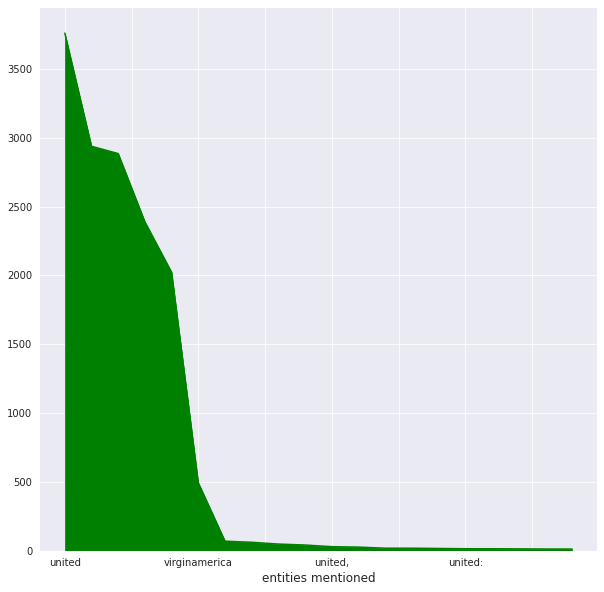

In [178]:
# Converting Array Tags into string and visualising them
split_data = df_data.copy()
split_data,split_data.tags = df_data.iloc[[i for i,j in enumerate(df_data['tags']) for value in j] , :],[value for i in df_data['tags'] for value in i]
split_data.tags.value_counts()[:20].plot.area(figsize=[10,10],color="g").set_xlabel('entities mentioned')
#Maximum tweets mentioned {united airways},then {virginamerica}

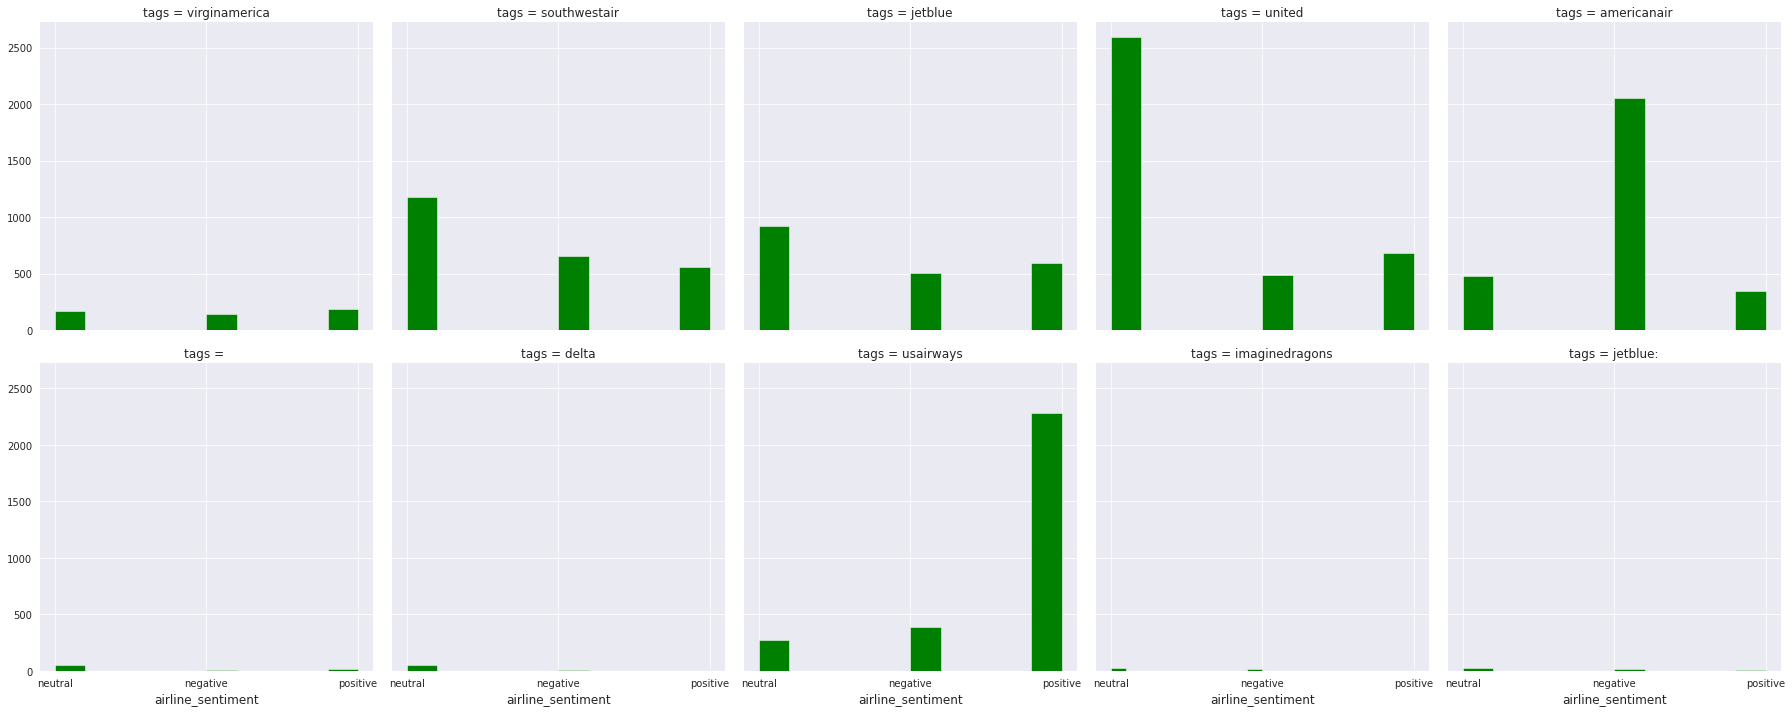

In [179]:
raw_df = split_data[(split_data.tags.isin(split_data.tags.value_counts()[:10].index.to_list()))]
a = sns.FacetGrid(raw_df,col="tags",col_wrap=5, height=5,aspect =1)
a = a.map(plt.hist,'airline_sentiment',color='g')
# virgin america airways have almost equal number of positive negative and neutral
# southwestair have neutral higher means it is ok for airline to continue
# most negative are of american air which shd be a pressing issue
# positive sentiment is maximum for usairways 

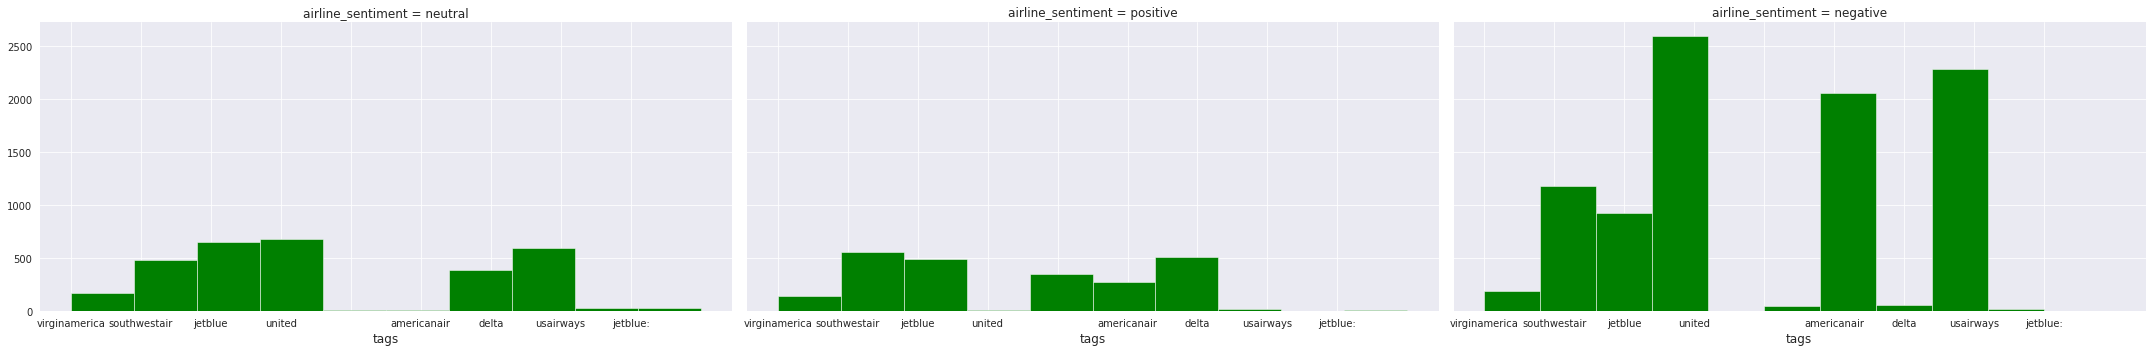

In [180]:
a = sns.FacetGrid(raw_df,col="airline_sentiment",col_wrap=3, height=5,aspect =2)
a = a.map(plt.hist,'tags',color='g')

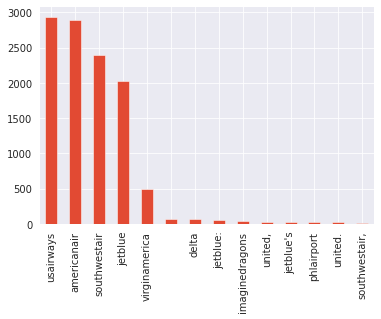

In [181]:
split_data.tags.value_counts()[1:15].plot.bar()

Text(0.5, 0, '')

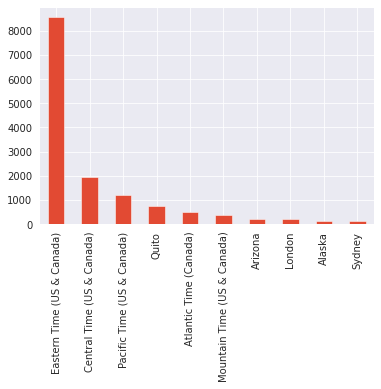

In [182]:
#Top 10 Timezones
df_data['user_timezone'].value_counts().sort_values(ascending=False)[:10].plot.bar().set_xlabel('')

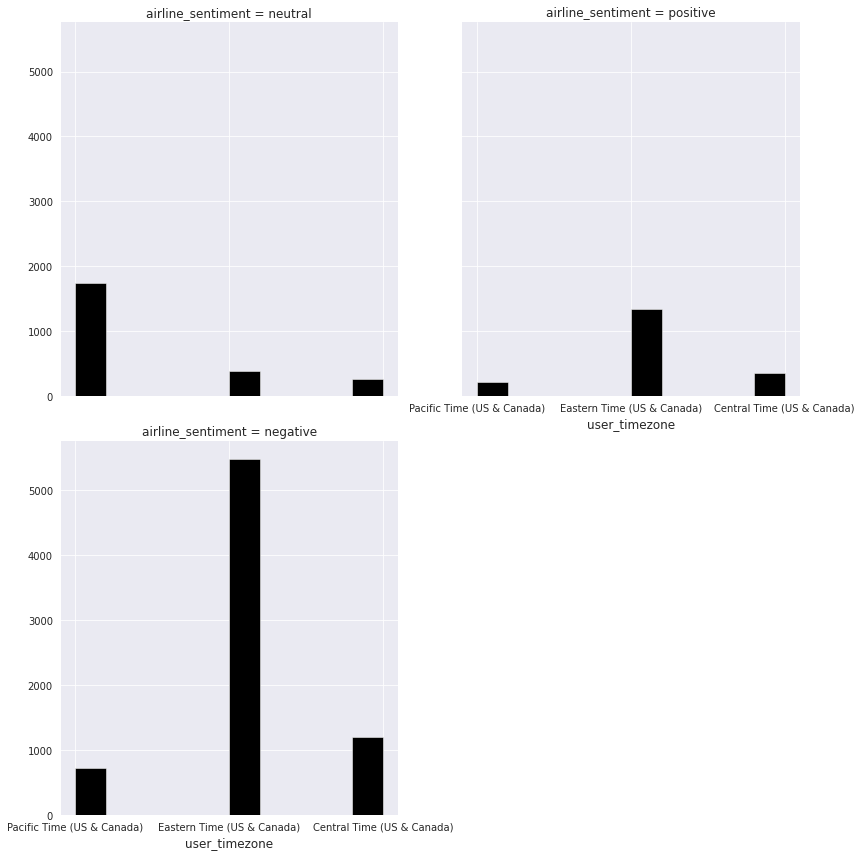

In [183]:
# Top 3 timezones with tweets in comparision to sentiment
a=sns.FacetGrid(df_data[df_data['user_timezone'].isin(df_data.user_timezone.value_counts()[:3].index.to_list())],col='airline_sentiment',col_wrap=2,height=6,)
a=a.map(plt.hist,'user_timezone',color='0')

Text(0.5, 0, 'Sentiments_Division')

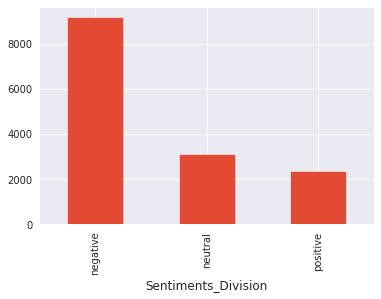

In [184]:
df_data['airline_sentiment'].value_counts().plot.bar().set_xlabel('Sentiments_Division')
# Out of 14500 Tweets it is visible that more than 70% of tweets have negative sentiment
# It can also be a problem which can be more clearly told after topic or entities are separated from text with respect to sentiment

In [ ]:
dictionary_LDA = gensim.corpora.Dictionary(df_data.tokenised_text)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in df_data.tokenised_text]
%time lda_model = models.LdaModel(corpus, num_topics=50,id2word=dictionary_LDA,passes=4,alpha=[0.01]*50,eta=[0.01]*len(dictionary_LDA.keys()))

In [187]:
# CommonTopics With Thier Occurent With Chars
for i,topic in lda_model.show_topics(formatted=True, num_topics=10):
    print(topic)
lda_model[corpus[1]]

0.149*"make" + 0.063*"without" + 0.059*"food" + 0.056*"calls" + 0.050*"dca" + 0.040*"name" + 0.037*"monday" + 0.036*"ord" + 0.032*"cool" + 0.031*"us"
0.108*"home" + 0.081*"get" + 0.058*"tonight" + 0.053*"already" + 0.053*"30" + 0.040*"calling" + 0.031*"us" + 0.031*"every" + 0.031*"week" + 0.027*"trying"
0.201*"like" + 0.119*"take" + 0.044*"would" + 0.043*"job" + 0.040*"busy" + 0.033*"looks" + 0.033*"instead" + 0.029*"saying" + 0.028*"get" + 0.027*"coming"
0.080*"twitter" + 0.076*"contact" + 0.056*"went" + 0.048*"possible" + 0.047*"bos" + 0.046*"return" + 0.043*"100" + 0.030*"winter" + 0.028*"part" + 0.028*"nashville"
0.317*"service" + 0.243*"customer" + 0.037*"experience" + 0.037*"poor" + 0.030*"terrible" + 0.025*"charlotte" + 0.024*"rep" + 0.021*"horrible" + 0.018*"allow" + 0.015*"members"
0.186*"work" + 0.105*"system" + 0.079*"nice" + 0.060*"5" + 0.059*"wife" + 0.041*"might" + 0.036*"last" + 0.026*"traveling" + 0.025*"happens" + 0.022*"kids"
0.152*"bag" + 0.121*"told" + 0.054*"w" + 0

[(16, 0.22444445), (24, 0.22444445), (32, 0.22444445), (39, 0.22444445)]

In [188]:
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

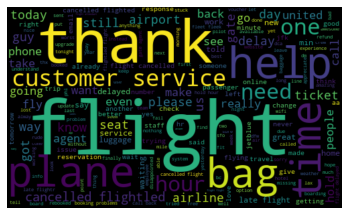

In [189]:
# WordCloudVisualisation
allWords = ' '.join([twts for twts in df_data.text])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear"),plt.axis('off')
plt.show()

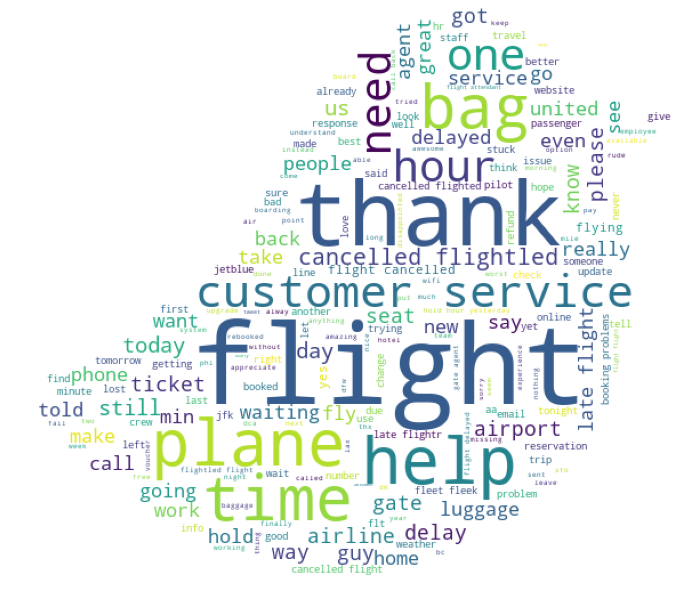

In [190]:
# Most Frequent Words In Whole Text
mask = np.array(Image.open(requests.get('http://www.clker.com/cliparts/F/O/V/V/E/w/tweeter-bird-hi.png', stream=True).raw))
generate_wordcloud(' '.join([twts for twts in df_data.text]), mask)

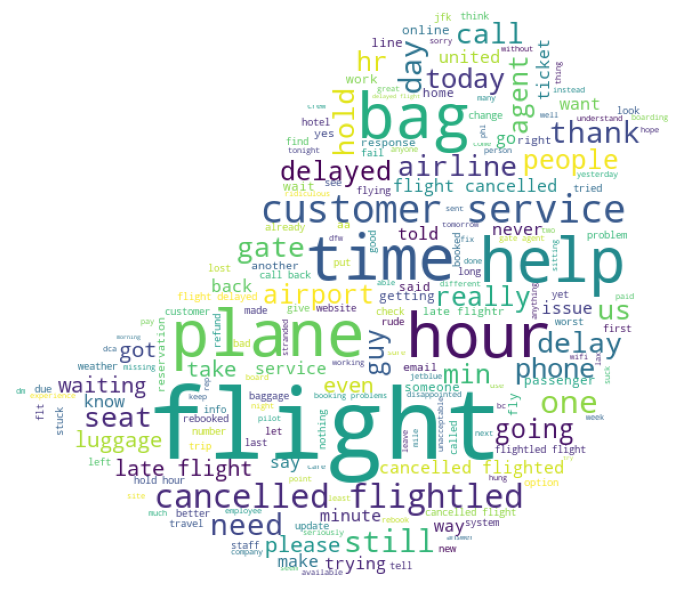

In [191]:
# Most Frequent Words In Negative Labeled Sentiment
generate_wordcloud(' '.join([twts for twts in df_data.loc[df_data["airline_sentiment"] == "negative", 'text']]), mask)

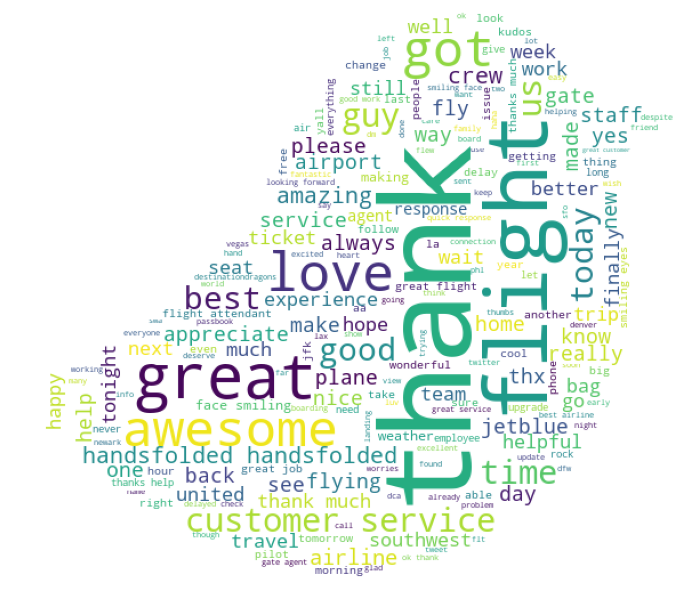

In [192]:
# Most Frequent Word In Positive Labeled Sentiment
generate_wordcloud(' '.join([twts for twts in df_data.loc[df_data["airline_sentiment"] == "positive", 'text']]), mask)

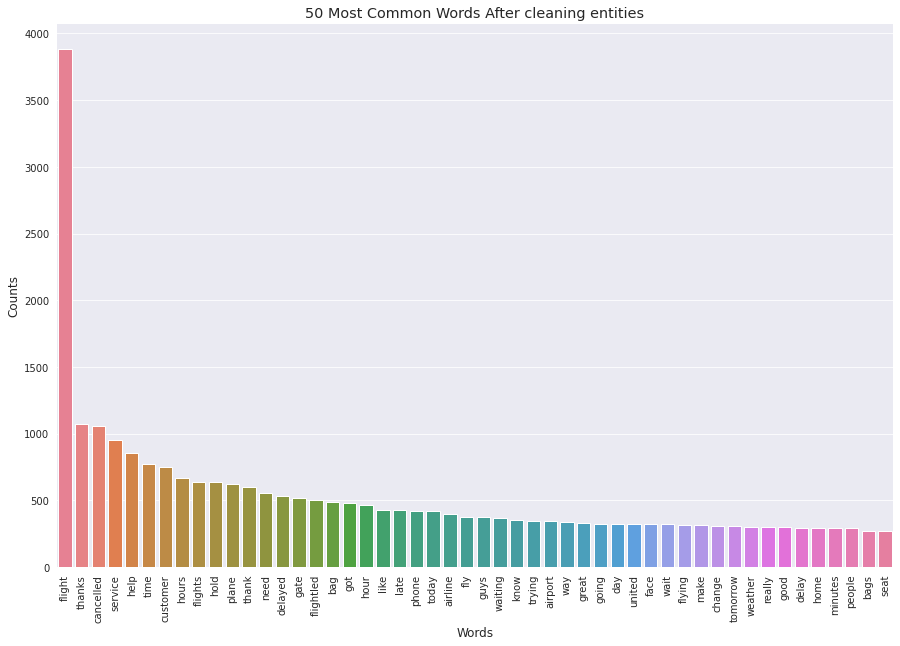

In [193]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df_data['text'])

# Visualise the 50 most common words after cleaning entities and text
common_words(count_data, count_vectorizer)

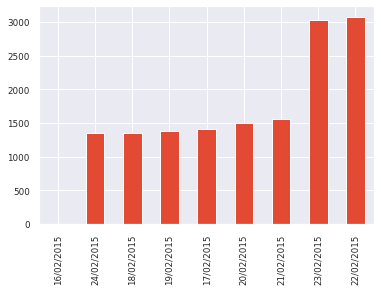

In [194]:
# Tweet Created Frequency v/s Time Distribution
df_data.tweet_created.value_counts().sort_values(ascending=True).plot.bar()

In [197]:
df_data['tweet_created']= pd.to_datetime(df['tweet_created'])
df_data['tweet_time'] = df_data.tweet_created.apply(lambda d : "day" if datetime.datetime.time(d).hour >=6 and datetime.datetime.time(d).hour<18 else "evening or night" )

Text(0.5, 0, 'timing of tweet')

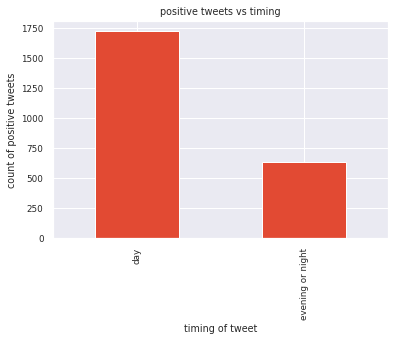

In [198]:
# positive tweets vs timing
f = df_data.tweet_time[df_data['airline_sentiment'] == 'positive'].value_counts().plot.bar()
f.set_title('positive tweets vs timing')
f.set_ylabel('count of positive tweets')
f.set_xlabel('timing of tweet')

Text(0.5, 0, 'timing of tweet')

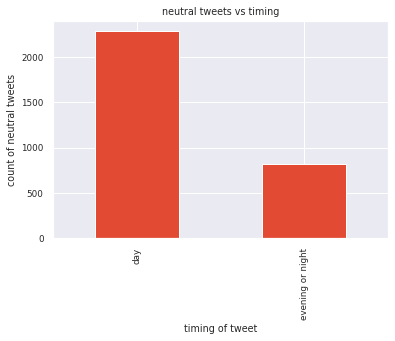

In [199]:
# neutral tweets vs timing
f1 = df_data.tweet_time[df_data['airline_sentiment'] == 'neutral'].value_counts().plot.bar()
f1.set_title('neutral tweets vs timing')
f1.set_ylabel('count of neutral tweets')
f1.set_xlabel('timing of tweet')

Text(0.5, 0, 'timing of tweet')

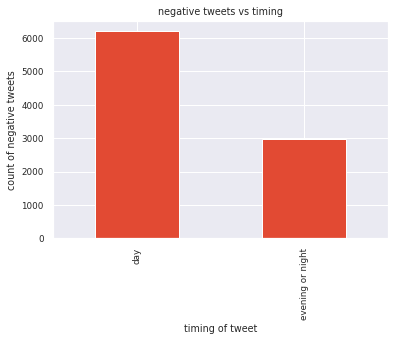

In [200]:
# negative tweets vs timing
f2 = df_data.tweet_time[df_data['airline_sentiment'] == 'negative'].value_counts().plot.bar()
f2.set_title('negative tweets vs timing')
f2.set_ylabel('count of negative tweets')
f2.set_xlabel('timing of tweet')

In [201]:
#US Airlines Fetch
entities = [ i['node']['name'] for i in requests.get('https://cache-api.ranker.com/lists/386932/items?limit=200&offset=0').json()['listItems']]
tags = list(dict.fromkeys([ j for i in df_data.tags for j in i]))

In [202]:
#Positive Negative Neutral Labeled Text Tokenised
positiveTokens = word_tokenize(' '.join([i for i in df_data.loc[df_data['airline_sentiment'] == 'positive']['text']]))
negativeTokens = word_tokenize(' '.join([i for i in df_data.loc[df_data['airline_sentiment'] == 'negative']['text']]))
neutralTokens  = word_tokenize(' '.join([i for i in df_data.loc[df_data['airline_sentiment'] == 'neutral']['text']]))
print("Positive Token - {}\nNegative Tokens - {}\nNeutral Tokens - {}".format(len(positiveTokens),len(negativeTokens),len(neutralTokens)))

Positive Token - 17837
Negative Tokens - 92343
Neutral Tokens - 22589


In [203]:
# Latitude Longitude Map Visualisation 
# One Time Run Code as it'll take approx 1 hour for 1000 rows aka 15 hours for given dataset so we've updated it in out dataset
if(int(input("Run? 0/1\n{0-False, 1-True\n"))):
  geolocator = Nominatim(user_agent="Mozilla/5.0 (Macintosh; U; PPC Mac OS X; fi-fi) AppleWebKit/420+ (KHTML, like Gecko) Safari/419.3")
  geocode = RateLimiter(geolocator.geocode, min_delay_seconds=2)
  df_data['coordinate'] = df_data['tweet_location'].apply(geocode)
  df_data['latitude'] = df_data.coordinate.apply(lambda x : x.latitude if x!= None else None)
  df_data['longitude'] = df_data.coordinate.apply(lambda x : x.longitude if x!= None else None)

Run? 0/1
{0-False, 1-True
0


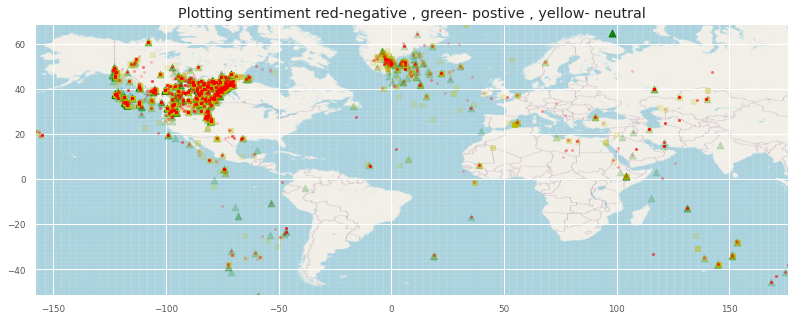

In [204]:
# Geographicial Representation of tweets origin location
BBox = (df_data.longitude.min(),df_data.longitude.max(),df_data.latitude.min(),df_data.latitude.max())
style.use('ggplot')
ruh_m = plt.imread('/content/drive/My Drive/internship/map.jpeg')
fig, sc = plt.subplots(figsize = (15,5))
sc.scatter(df_data[df_data['airline_sentiment']== 'positive'].longitude, df_data[df_data['airline_sentiment']== 'positive'].latitude, zorder=1, alpha= 0.2, c='g', s=50 ,marker= "^")
sc.scatter(df_data[df_data['airline_sentiment']== 'neutral'].longitude, df_data[df_data['airline_sentiment']== 'neutral'].latitude, zorder=1, alpha= 0.2, c='y', s=25 , marker="s")
sc.scatter(df_data[df_data['airline_sentiment']== 'negative'].longitude, df_data[df_data['airline_sentiment']== 'negative'].latitude, zorder=1, alpha= 0.2, c='r', s=5)
sc.set_title('Plotting sentiment red-negative , green- postive , yellow- neutral')
sc.set_xlim(BBox[0],BBox[1])
sc.set_ylim(BBox[2],BBox[3])
sc.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

<h1> <strong>Ongoing work on entity separation </strong></h1>

PolyGlot Approach For Entity Recogniton

In [37]:
#For Raw Text
entities = [Text(" ".join(i),hint_language_code='en').entities if Text(" ".join(i),hint_language_code='en').entities!=[] \
            else 1 for i in df[df['tokenised_text'].str.len()>0].tokenised_text ]

entitiesArray = [i for i in entities if i!=1]
emptyEntities = [i for i in entities if i==1]

print("Total %s" % len(entitiesArray+emptyEntities))
print("Failed %s" % len(emptyEntities))
print("Success but can be inaccurate %s" % len(entitiesArray))

Total 14640
Failed 8962
Success but can be inaccurate 5678


In [39]:
df['PolyGlot_Entities'] = entities
df.head(20)[['text','PolyGlot_Entities']]

,text,PolyGlot_Entities
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,1
3,@VirginAmerica it's really aggressive to blast...,1
4,@VirginAmerica and it's a really big bad thing...,1
5,@VirginAmerica seriously would pay $30 a fligh...,1
6,"@VirginAmerica yes, nearly every time I fly VX...",[[”]]
7,@VirginAmerica Really missed a prime opportuni...,1
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",1
9,"@VirginAmerica it was amazing, and arrived an ...",1


In [26]:
#For PRE-Processed Text {HREF LINKS REMOVED, HTML TEXT REMOVED, WORDS LEMMATIZED , PUNCTUATIONS ARE REMOVED}
entities = [Text(" ".join(i),hint_language_code='en').entities if Text(" ".join(i),hint_language_code='en').entities!=[] \
            else 1 for i in df1[df1['tokenised_text'].str.len()>0].tokenised_text ]

entitiesArray = [i for i in entities if i!=1]
emptyEntities = [i for i in entities if i==1]

print("Total %s" % len(entitiesArray+emptyEntities))
print("Failed %s" % len(emptyEntities))
print("Success but can be inaccurate %s" % len(entitiesArray))

Total 14640
Failed 7971
Success but can be inaccurate 6669


In [35]:
df1['PolyGlot Entities'] = entities
df1.head(20)[['text','PolyGlot Entities']]

,text,PolyGlot Entities
0,virginamerica what dhepburn said,[[dhepburn]]
1,virginamerica plus you have added commercials ...,1
2,virginamerica i did not today must mean i need...,1
3,virginamerica it is really aggressive to blast...,1
4,virginamerica and it is a really big bad thing...,1
5,virginamerica seriously would pay 30 a flight ...,[[virginamerica]]
6,virginamerica yes nearly every time i fly vx t...,1
7,virginamerica really missed a prime opportunit...,[[virginamerica]]
8,virginamerica well i did notbut now i do d,1
9,virginamerica it was amazing and arrived an ho...,1


In [ ]:
df_data[df_data['text'].str.len()>1]

In [ ]:
#Stanford NER Approach - python distro is obsolete
tagger = nerer.HttpNER(host='127.0.0.1', port=8080)
checker = [tagger.get_entities(i) for i in df.text]
checker.count({})

In [74]:
#NLTK Approach for NER
for i in df.text:
  sentence = df.text[i]
  tokens = nltk.word_tokenize(sentence)
  tagged = nltk.pos_tag(tokens)
  entities = nltk.chunk.ne_chunk(tagged)
  if("ORGANIZATION" in str(entities)): scount =

In [68]:
scount = 0
fcount = 0
def work(i):
  global scount,fcount
  # sentence = " ".join(i)
  tokens = nltk.word_tokenize(i)
  tagged = nltk.pos_tag(tokens)
  entities = nltk.chunk.ne_chunk(tagged)
  if( "organization" in str(entities).lower()):
    scount+=1
  else: fcount+=1
  return entities
df1['Entity_Set'] = df1.text.apply(lambda x: work(x))

In [53]:
# Success Accurate Count And Failed Count  
scount,fcount

(8706, 5934)

In [52]:
for i in range(50):
  print(df['text'][i],list(df['Entity_Set'][i]),sep=" : ")

@VirginAmerica What @dhepburn said. : [('@', 'NN'), Tree('ORGANIZATION', [('VirginAmerica', 'NNP')]), ('What', 'WP'), ('@', 'NNP'), ('dhepburn', 'NN'), ('said', 'VBD'), ('.', '.')]
@VirginAmerica plus you've added commercials to the experience... tacky. : [('@', 'NN'), Tree('ORGANIZATION', [('VirginAmerica', 'NNP')]), ('plus', 'CC'), ('you', 'PRP'), ("'ve", 'VBP'), ('added', 'VBN'), ('commercials', 'NNS'), ('to', 'TO'), ('the', 'DT'), ('experience', 'NN'), ('...', ':'), ('tacky', 'NN'), ('.', '.')]
@VirginAmerica I didn't today... Must mean I need to take another trip! : [('@', 'NN'), ('VirginAmerica', 'NNP'), ('I', 'PRP'), ('did', 'VBD'), ("n't", 'RB'), ('today', 'NN'), ('...', ':'), ('Must', 'NNP'), ('mean', 'VB'), ('I', 'PRP'), ('need', 'VBP'), ('to', 'TO'), ('take', 'VB'), ('another', 'DT'), ('trip', 'NN'), ('!', '.')]
@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse : [('@', 'NN'), ('VirginAmerica', 'NNP

In [67]:
pattern = 'NP: {<NNP>?}'
cp = nltk.RegexpParser(pattern)
cs = cp.parse(df['Entity_Set'][0])
print(cs)

(S
  @/NN
  (ORGANIZATION VirginAmerica/NNP)
  What/WP
  (NP @/NNP)
  dhepburn/NN
  said/VBD
  ./.)


In [112]:
pattern = 'NNP: {<NNP>+}'
cp = nltk.RegexpParser(pattern)
chunked = cp.parse(df['Entity_Set'][0])

In [123]:
for subtree in chunked.subtrees():
  print(subtree.leaves()[0])

('@', 'NN')
('VirginAmerica', 'NNP')
('@', 'NNP')


In [116]:
for subtree in chunked.subtrees(filter=lambda t: t.label() == 'NNP'):
  print(subtree)

(NNP @/NNP)


In [90]:
d = df['Entity_Set'][0]
for i in d:
  print(i)

('@', 'NN')
(ORGANIZATION VirginAmerica/NNP)
('What', 'WP')
('@', 'NNP')
('dhepburn', 'NN')
('said', 'VBD')
('.', '.')
